In [1]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [2]:
import torch
import torch.nn as nn
from torchvision.datasets import CIFAR10 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
from torchsummary import summary
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision.models.feature_extraction import create_feature_extractor,get_graph_node_names
import matplotlib.pyplot as plt
from torchvision.models import vgg16_bn


In [3]:
torch.cuda.empty_cache()

In [4]:
CUDA_LAUNCH_BLOCKING=1

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
torch.manual_seed(43)

In [7]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean =[0.4914, 0.4822, 0.4465],std =[0.2023, 0.1994, 0.2010])
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean =[0.4914, 0.4822, 0.4465],std =[0.2023, 0.1994, 0.2010])
])

In [8]:
train_dataset = CIFAR10(root = './cifar10', train=True, download=True, transform=train_transform)
test_dataset = CIFAR10(root='./cifar10', train=False, download=True, transform=val_transform)

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
print(f'train_size is: {len(train_dataset)} , valid_size is: {len(val_dataset)} , test_size is: {len(test_dataset)}')

Files already downloaded and verified
Files already downloaded and verified
train_size is: 45000 , valid_size is: 5000 , test_size is: 10000


In [9]:
batch_size = 128
# Define DataLoader for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)



In [10]:
class NEW_VGG16(nn.Module):
    def __init__(self):
        super(NEW_VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )


    def forward(self, x):
        x = self.features(x)
        return x

In [11]:
# Define the VGG16 model
model = NEW_VGG16().to(device)
original_model_path = 'best_model_weights.pth'
model.load_state_dict(torch.load(original_model_path), strict=False)



_IncompatibleKeys(missing_keys=[], unexpected_keys=['classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias', 'features.37.weight', 'features.37.bias', 'features.38.weight', 'features.38.bias', 'features.38.running_mean', 'features.38.running_var', 'features.38.num_batches_tracked', 'features.40.weight', 'features.40.bias', 'features.41.weight', 'features.41.bias', 'features.41.running_mean', 'features.41.running_var', 'features.41.num_batches_tracked'])

In [12]:
for i, layer in enumerate(model.features):
    print(f"Layer {i}: {layer}")

Layer 0: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 1: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Layer 2: ReLU(inplace=True)
Layer 3: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 4: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Layer 5: ReLU(inplace=True)
Layer 6: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Layer 7: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 8: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Layer 9: ReLU(inplace=True)
Layer 10: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 11: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Layer 12: ReLU(inplace=True)
Layer 13: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Layer 14: Conv2d(128, 256, kernel_size=(3, 3), stride=(1

In [12]:
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

In [13]:
import torch
from torch.utils.data import Subset, DataLoader

num_classes = 10
samples_per_class_train = 1000 // num_classes
samples_per_class_test = 100 // num_classes

selected_indices_train = []
class_counter_train = [0] * num_classes

for index, (data, label) in enumerate(train_dataset):
    if class_counter_train[label] < samples_per_class_train:
        selected_indices_train.append(index)
        class_counter_train[label] += 1

    if all(count == samples_per_class_train for count in class_counter_train):
        break

balanced_train_subset = Subset(train_dataset, selected_indices_train)

selected_indices_test = []
class_counter_test = [0] * num_classes

for index, (data, label) in enumerate(test_dataset):
    if class_counter_test[label] < samples_per_class_test:
        selected_indices_test.append(index)
        class_counter_test[label] += 1

    if all(count == samples_per_class_test for count in class_counter_test):
        break

balanced_test_subset = Subset(test_dataset, selected_indices_test)

balanced10_train_loader = DataLoader(balanced_train_subset, batch_size = 1000, shuffle=True)
balanced10_test_loader = DataLoader(balanced_test_subset, batch_size = 100, shuffle=False)

In [14]:
last_feature_outputs = []
last_feature_labels = []
for images, labels in balanced10_train_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    last_feature_outputs.append(outputs)
    last_feature_labels.append(labels)

all_outputs = torch.cat(last_feature_outputs, dim=0)
all_labels = torch.cat(last_feature_labels, dim=0)
print(all_outputs.shape)
print(all_labels.shape)

torch.Size([1000, 512, 2, 2])
torch.Size([1000])


In [15]:
labels = all_labels.view(-1)
outputs = all_outputs.view(all_outputs.shape[0],-1)
print(labels.shape)
print(outputs.shape)

torch.Size([1000])
torch.Size([1000, 2048])


In [16]:
def center_si(data, labels, classes):
    data = data.view(data.size(0), -1).to(device)
    class_centers = torch.zeros((len(classes), data.shape[-1]), device = data.device)

    for i in classes:
        data_class = data[labels == i, :]
        class_centers[i, :] = data_class.mean(0)

    center_dist = torch.cdist(data, class_centers, p=2)
    _, indices = torch.sort(center_dist)
    near_class_centers = indices[:, 0]
    correct_data = (labels == near_class_centers) * 1.0

    return correct_data.sum(0) / len(data)


In [17]:
csi = center_si(outputs, labels, classes= range(10))
csi

tensor(0.9580, device='cuda:0')

In [29]:
import numpy as np
n_features_max = 512*2*2
features_idx = []
csi_n = np.zeros(n_features_max)
for n_features in tqdm(range(n_features_max),desc= 'Number of features selected'):
    for i_feature in tqdm(set(range(n_features_max)) - set(features_idx),leave=False,desc= "searching features"):
        if len(features_idx)==0:
            features_idx = [i_feature]
        else:
            features_idx[-1] = i_feature

        csi = center_si(outputs[:,features_idx], labels, classes= range(10))
        if csi > csi_n[n_features]:
            best_idx = i_feature
            csi_n[n_features] = csi
    features_idx[-1]=best_idx
    if n_features != n_features_max-1:
        features_idx.append(best_idx)
        


searching features:  39%|██████████████████████▉                                    | 797/2046 [00:01<00:03, 396.54it/s]


searching features:   2%|█▏                                                          | 39/2043 [00:00<00:05, 386.85it/s]


searching features:  72%|██████████████████████████████████████████                | 1478/2041 [00:03<00:01, 431.06it/s]


searching features:  50%|█████████████████████████████                             | 1023/2038 [00:02<00:02, 431.90it/s]


searching features:  26%|███████████████▎                                           | 529/2035 [00:01<00:03, 417.25it/s]


searching features:   4%|██▌                                                         | 88/2032 [00:00<00:04, 433.94it/s]


searching features:  85%|█████████████████████████████████████████████████▍        | 1732/2030 [00:04<00:00, 427.59it/s]


searching features:  55%|███████████████████████████████▊                          | 1110/2027 [00:03<00:03, 302.15it/s]


searching features:  78%|████████████████████████████████████████████▉             | 1570/2025 [00:04<00:01, 388.50it/s]


searching features:  34%|████████████████████▎                                      | 697/2022 [00:01<00:03, 352.18it/s]


searching features:  89%|███████████████████████████████████████████████████▍      | 1792/2020 [00:04<00:00, 414.08it/s]


searching features:  54%|███████████████████████████████                           | 1081/2017 [00:02<00:02, 403.01it/s]


searching features:  19%|███████████▍                                               | 391/2014 [00:00<00:03, 410.33it/s]


searching features:  92%|█████████████████████████████████████████████████████▌    | 1856/2012 [00:04<00:00, 412.46it/s]


searching features:  62%|████████████████████████████████████                      | 1250/2009 [00:03<00:01, 412.19it/s]


searching features:  32%|███████████████████                                        | 646/2006 [00:01<00:03, 421.02it/s]


searching features:   0%|                                                                      | 0/2003 [00:00<?, ?it/s]


searching features:  73%|██████████████████████████████████████████▎               | 1460/2001 [00:03<00:01, 396.90it/s]


searching features:  45%|██████████████████████████▍                                | 895/1998 [00:02<00:02, 405.65it/s]


searching features:  17%|█████████▉                                                 | 336/1995 [00:00<00:03, 417.29it/s]


searching features:  90%|████████████████████████████████████████████████████      | 1788/1993 [00:04<00:00, 397.87it/s]


searching features:  59%|██████████████████████████████████▍                       | 1181/1990 [00:02<00:01, 404.82it/s]


searching features:  28%|████████████████▍                                          | 552/1987 [00:01<00:03, 397.68it/s]


Number of features selected:   3%|█▌                                                | 64/2048 [05:17<2:41:49,  4.89s/it]


searching features:  71%|█████████████████████████████████████████▏                | 1408/1982 [00:03<00:01, 419.94it/s]


searching features:  42%|████████████████████████▌                                  | 825/1979 [00:02<00:02, 400.12it/s]


searching features:  15%|█████████                                                  | 303/1976 [00:00<00:03, 427.59it/s]


searching features:  92%|█████████████████████████████████████████████████████▍    | 1819/1974 [00:04<00:00, 402.40it/s]


searching features:  60%|██████████████████████████████████▊                       | 1184/1971 [00:03<00:02, 351.47it/s]


searching features:  71%|█████████████████████████████████████████▍                | 1405/1968 [00:03<00:01, 420.10it/s]


searching features:  42%|████████████████████████▌                                  | 819/1965 [00:02<00:02, 399.25it/s]


searching features:  12%|███████▎                                                   | 244/1962 [00:00<00:04, 393.32it/s]


searching features:  86%|█████████████████████████████████████████████████▋        | 1679/1960 [00:04<00:00, 406.04it/s]


searching features:  57%|████████████████████████████████▉                         | 1110/1957 [00:02<00:02, 397.43it/s]


searching features:  30%|█████████████████▊                                         | 588/1954 [00:01<00:03, 414.08it/s]


searching features:   4%|██▌                                                         | 85/1951 [00:00<00:04, 417.99it/s]


searching features:  82%|███████████████████████████████████████████████▍          | 1595/1949 [00:03<00:00, 419.52it/s]


searching features:  56%|████████████████████████████████▋                         | 1097/1946 [00:02<00:02, 400.88it/s]


searching features:  29%|█████████████████▏                                         | 567/1943 [00:01<00:03, 393.43it/s]


searching features:   2%|█▎                                                          | 42/1940 [00:00<00:04, 415.06it/s]


searching features:  81%|██████████████████████████████████████████████▊           | 1564/1938 [00:03<00:00, 413.80it/s]


searching features:  59%|██████████████████████████████████                        | 1136/1935 [00:02<00:01, 414.12it/s]


searching features:  33%|███████████████████▋                                       | 645/1932 [00:01<00:03, 421.18it/s]


searching features:  11%|██████▍                                                    | 209/1929 [00:00<00:04, 373.71it/s]


searching features:  90%|████████████████████████████████████████████████████▏     | 1732/1927 [00:04<00:00, 390.85it/s]


searching features:  68%|███████████████████████████████████████▌                  | 1313/1924 [00:03<00:01, 404.89it/s]


searching features:  42%|████████████████████████▊                                  | 806/1921 [00:01<00:02, 409.79it/s]


searching features:  19%|███████████▍                                               | 370/1918 [00:00<00:03, 396.60it/s]


searching features:  99%|█████████████████████████████████████████████████████████▍| 1898/1916 [00:04<00:00, 401.01it/s]


searching features:  78%|█████████████████████████████████████████████▍            | 1500/1913 [00:03<00:01, 412.76it/s]


searching features:  59%|██████████████████████████████████▎                       | 1132/1910 [00:02<00:01, 419.25it/s]


searching features:  39%|██████████████████████▊                                    | 739/1907 [00:01<00:02, 391.29it/s]


searching features:  15%|█████████                                                  | 293/1904 [00:00<00:03, 413.58it/s]


searching features:  97%|████████████████████████████████████████████████████████▎ | 1846/1902 [00:04<00:00, 407.51it/s]


searching features:  74%|███████████████████████████████████████████▏              | 1413/1899 [00:03<00:01, 387.12it/s]


searching features:  54%|███████████████████████████████▌                          | 1032/1896 [00:02<00:02, 397.91it/s]


searching features:  38%|██████████████████████▏                                    | 713/1893 [00:01<00:02, 415.97it/s]


searching features:  14%|████████▎                                                  | 268/1890 [00:00<00:04, 360.92it/s]


searching features:  98%|████████████████████████████████████████████████████████▊ | 1848/1888 [00:04<00:00, 404.47it/s]


searching features:  75%|███████████████████████████████████████████▌              | 1416/1885 [00:03<00:01, 415.24it/s]


searching features:  57%|████████████████████████████████▊                         | 1064/1882 [00:02<00:02, 392.32it/s]


searching features:  40%|███████████████████████▌                                   | 751/1879 [00:01<00:02, 407.35it/s]


searching features:  19%|███████████▍                                               | 365/1876 [00:00<00:03, 398.24it/s]


searching features:   0%|                                                                      | 0/1873 [00:00<?, ?it/s]


searching features:  81%|██████████████████████████████████████████████▉           | 1516/1871 [00:03<00:00, 375.44it/s]


searching features:  62%|████████████████████████████████████                      | 1160/1868 [00:02<00:01, 408.06it/s]


searching features:  37%|█████████████████████▉                                     | 695/1865 [00:01<00:03, 382.77it/s]


searching features:   2%|█▎                                                          | 42/1862 [00:00<00:04, 419.45it/s]


searching features:  78%|█████████████████████████████████████████████             | 1446/1860 [00:03<00:01, 379.95it/s]


searching features:  54%|███████████████████████████████▎                          | 1003/1857 [00:02<00:02, 382.91it/s]


searching features:  36%|█████████████████████                                      | 660/1854 [00:01<00:02, 409.26it/s]


searching features:  16%|█████████▌                                                 | 301/1851 [00:00<00:04, 371.43it/s]


searching features:   0%|                                                                      | 0/1848 [00:00<?, ?it/s]


searching features:  87%|██████████████████████████████████████████████████▎       | 1602/1846 [00:04<00:00, 396.91it/s]


searching features:  72%|█████████████████████████████████████████▉                | 1334/1843 [00:03<00:01, 394.32it/s]


searching features:  57%|█████████████████████████████████▏                        | 1054/1840 [00:02<00:01, 403.70it/s]


searching features:  43%|█████████████████████████▌                                 | 796/1837 [00:01<00:02, 407.87it/s]


searching features:  27%|███████████████▋                                           | 487/1834 [00:01<00:03, 402.90it/s]


searching features:   8%|████▋                                                      | 144/1831 [00:00<00:05, 315.71it/s]


searching features:  85%|█████████████████████████████████████████████████▎        | 1556/1829 [00:03<00:00, 382.57it/s]


searching features:  71%|█████████████████████████████████████████▎                | 1300/1826 [00:03<00:01, 368.60it/s]


searching features:  57%|█████████████████████████████████▎                        | 1048/1823 [00:02<00:01, 388.34it/s]


searching features:  45%|██████████████████████████▎                                | 812/1820 [00:02<00:02, 369.78it/s]


searching features:  33%|███████████████████▌                                       | 603/1817 [00:01<00:02, 421.49it/s]


searching features:  20%|███████████▌                                               | 357/1814 [00:00<00:03, 387.77it/s]


searching features:   9%|█████▏                                                     | 158/1811 [00:00<00:04, 400.11it/s]


Number of features selected:  12%|█████▋                                           | 240/2048 [19:14<2:17:55,  4.58s/it]


searching features:  89%|███████████████████████████████████████████████████▊      | 1612/1806 [00:04<00:00, 389.85it/s]


searching features:  77%|████████████████████████████████████████████▍             | 1381/1803 [00:03<00:01, 400.69it/s]


searching features:  65%|█████████████████████████████████████▉                    | 1177/1800 [00:03<00:01, 382.41it/s]


searching features:  85%|█████████████████████████████████████████████████▍        | 1533/1797 [00:03<00:00, 407.01it/s]


searching features:  63%|████████████████████████████████████▌                     | 1131/1794 [00:03<00:02, 331.03it/s]


searching features:  16%|█████████▍                                                 | 285/1791 [00:00<00:04, 326.79it/s]


searching features:  99%|█████████████████████████████████████████████████████████▋| 1779/1789 [00:04<00:00, 389.11it/s]


searching features:  83%|████████████████████████████████████████████████▎         | 1486/1786 [00:04<00:00, 332.46it/s]


searching features:  71%|█████████████████████████████████████████▏                | 1268/1783 [00:03<00:01, 440.18it/s]


searching features:  63%|████████████████████████████████████▌                     | 1124/1780 [00:02<00:01, 396.05it/s]


searching features:  60%|██████████████████████████████████▋                       | 1061/1777 [00:02<00:01, 394.29it/s]


searching features:  54%|████████████████████████████████▏                          | 966/1774 [00:02<00:01, 458.41it/s]


searching features:  55%|████████████████████████████████▍                          | 974/1771 [00:02<00:02, 374.18it/s]


searching features:  60%|██████████████████████████████████▌                       | 1053/1768 [00:02<00:01, 382.33it/s]


searching features:  75%|███████████████████████████████████████████▏              | 1316/1765 [00:03<00:01, 407.53it/s]


searching features:  89%|███████████████████████████████████████████████████▊      | 1574/1762 [00:03<00:00, 370.83it/s]


searching features:  91%|████████████████████████████████████████████████████▋     | 1596/1759 [00:03<00:00, 453.21it/s]


searching features:  88%|███████████████████████████████████████████████████▎      | 1554/1756 [00:03<00:00, 407.58it/s]


searching features:  93%|█████████████████████████████████████████████████████▊    | 1628/1753 [00:04<00:00, 389.44it/s]


searching features:   6%|███▎                                                       | 100/1749 [00:00<00:03, 485.48it/s]


searching features:  18%|██████████▉                                                | 323/1746 [00:00<00:03, 392.15it/s]


searching features:  36%|█████████████████████▏                                     | 626/1743 [00:01<00:02, 446.49it/s]


searching features:  48%|████████████████████████████▏                              | 831/1740 [00:02<00:02, 452.32it/s]


searching features:  73%|██████████████████████████████████████████▏               | 1264/1737 [00:03<00:01, 397.45it/s]


searching features:  87%|██████████████████████████████████████████████████▋       | 1516/1734 [00:03<00:00, 365.34it/s]


searching features:  96%|███████████████████████████████████████████████████████▌  | 1659/1731 [00:04<00:00, 379.74it/s]


searching features:  86%|█████████████████████████████████████████████████▌        | 1478/1728 [00:04<00:00, 360.91it/s]


searching features:  12%|███████▎                                                   | 213/1725 [00:00<00:04, 303.35it/s]


searching features:  75%|███████████████████████████████████████████▎              | 1287/1723 [00:03<00:01, 349.06it/s]


searching features:  78%|█████████████████████████████████████████████▎            | 1345/1720 [00:03<00:00, 411.93it/s]


searching features:  95%|███████████████████████████████████████████████████████   | 1630/1717 [00:04<00:00, 383.90it/s]


searching features:  18%|██████████▋                                                | 309/1713 [00:00<00:03, 386.25it/s]


searching features:  32%|███████████████████                                        | 551/1710 [00:01<00:02, 442.37it/s]


searching features:  57%|█████████████████████████████████▊                         | 978/1707 [00:02<00:01, 437.11it/s]


searching features:  83%|████████████████████████████████████████████████▍         | 1422/1704 [00:03<00:00, 371.21it/s]


searching features:   5%|██▊                                                         | 80/1700 [00:00<00:04, 388.96it/s]


searching features:  88%|███████████████████████████████████████████████████▎      | 1501/1698 [00:04<00:00, 327.44it/s]


searching features:  97%|████████████████████████████████████████████████████████▍ | 1650/1695 [00:03<00:00, 421.89it/s]


searching features:  24%|█████████████▉                                             | 400/1691 [00:00<00:02, 439.37it/s]


searching features:  49%|█████████████████████████████▏                             | 834/1688 [00:01<00:02, 398.28it/s]


searching features:  87%|██████████████████████████████████████████████████▍       | 1466/1685 [00:03<00:00, 409.15it/s]


searching features:  21%|████████████▋                                              | 361/1681 [00:00<00:03, 398.75it/s]


searching features:  57%|█████████████████████████████████▊                         | 963/1678 [00:02<00:01, 456.43it/s]


searching features:  91%|████████████████████████████████████████████████████▌     | 1519/1675 [00:03<00:00, 448.21it/s]


searching features:  17%|█████████▊                                                 | 278/1671 [00:00<00:03, 452.97it/s]


searching features:  54%|████████████████████████████████                           | 905/1668 [00:02<00:01, 426.39it/s]


searching features:  95%|███████████████████████████████████████████████████████   | 1581/1665 [00:04<00:00, 344.07it/s]


searching features:  18%|██████████▊                                                | 303/1662 [00:01<00:05, 269.40it/s]


searching features:  93%|█████████████████████████████████████████████████████▊    | 1540/1660 [00:04<00:00, 373.35it/s]


searching features:  17%|██████████                                                 | 281/1656 [00:00<00:03, 446.50it/s]


searching features:  69%|███████████████████████████████████████▉                  | 1137/1653 [00:02<00:01, 450.75it/s]


searching features:  17%|██████████▎                                                | 287/1649 [00:00<00:03, 414.29it/s]


searching features:  63%|████████████████████████████████████▌                     | 1037/1646 [00:02<00:01, 407.85it/s]


searching features:   9%|█████▍                                                     | 153/1642 [00:00<00:03, 489.82it/s]


searching features:  66%|██████████████████████████████████████▍                   | 1087/1639 [00:02<00:01, 445.81it/s]


searching features:  12%|██████▉                                                    | 191/1635 [00:00<00:03, 471.34it/s]


searching features:  60%|███████████████████████████████████▏                       | 972/1632 [00:02<00:01, 449.45it/s]


searching features:  12%|██████▊                                                    | 188/1628 [00:00<00:03, 463.71it/s]


searching features:  66%|██████████████████████████████████████▏                   | 1070/1625 [00:02<00:01, 377.35it/s]


searching features:  20%|███████████▊                                               | 323/1621 [00:00<00:03, 361.68it/s]


searching features:  82%|███████████████████████████████████████████████▌          | 1326/1618 [00:02<00:00, 423.83it/s]


searching features:  48%|████████████████████████████                               | 769/1614 [00:01<00:02, 407.42it/s]


searching features:  12%|██████▉                                                    | 189/1610 [00:00<00:03, 428.21it/s]


searching features:  75%|███████████████████████████████████████████▋              | 1209/1607 [00:02<00:00, 422.99it/s]


searching features:  37%|█████████████████████▌                                     | 586/1603 [00:01<00:02, 454.45it/s]


searching features: 100%|█████████████████████████████████████████████████████████▊| 1596/1600 [00:03<00:00, 455.29it/s]


searching features:  68%|███████████████████████████████████████▍                  | 1086/1596 [00:02<00:01, 368.46it/s]


searching features:  11%|██████▋                                                    | 180/1592 [00:00<00:04, 332.85it/s]


searching features:  71%|█████████████████████████████████████████▏                | 1130/1589 [00:02<00:00, 460.78it/s]


searching features:  36%|█████████████████████                                      | 566/1585 [00:01<00:02, 471.93it/s]


searching features:   3%|█▊                                                          | 49/1581 [00:00<00:03, 480.85it/s]


searching features:  71%|████████████████████████████████████████▉                 | 1113/1578 [00:02<00:01, 463.38it/s]


searching features:  37%|█████████████████████▋                                     | 577/1574 [00:01<00:02, 459.42it/s]


searching features:   3%|█▊                                                          | 48/1570 [00:00<00:03, 470.96it/s]


searching features:  82%|███████████████████████████████████████████████▍          | 1283/1567 [00:03<00:00, 437.17it/s]


searching features:  52%|██████████████████████████████▊                            | 815/1563 [00:01<00:01, 432.40it/s]


searching features:  27%|███████████████▉                                           | 422/1559 [00:00<00:02, 408.11it/s]


searching features:   6%|███▋                                                        | 95/1555 [00:00<00:03, 473.59it/s]


searching features:  84%|████████████████████████████████████████████████▉         | 1308/1552 [00:03<00:00, 415.44it/s]


searching features:  64%|█████████████████████████████████████▌                     | 987/1548 [00:02<00:01, 470.29it/s]


searching features:  34%|████████████████████▎                                      | 532/1544 [00:01<00:02, 343.07it/s]


searching features:   0%|                                                                      | 0/1540 [00:00<?, ?it/s]


searching features:  29%|█████████████████▎                                         | 450/1537 [00:01<00:02, 447.04it/s]


searching features:  12%|███████▏                                                   | 186/1533 [00:00<00:03, 402.74it/s]


searching features:  98%|█████████████████████████████████████████████████████████ | 1504/1530 [00:03<00:00, 426.53it/s]


searching features:  65%|██████████████████████████████████████▌                    | 996/1526 [00:02<00:01, 468.08it/s]


searching features:  41%|███████████████████████▉                                   | 618/1522 [00:01<00:02, 395.60it/s]


searching features:  99%|█████████████████████████████████████████████████████████▏| 1498/1519 [00:03<00:00, 356.25it/s]


searching features:   3%|█▋                                                          | 43/1515 [00:00<00:03, 422.58it/s]


searching features:  66%|██████████████████████████████████████▌                   | 1005/1512 [00:02<00:01, 427.45it/s]


searching features:  44%|█████████████████████████▋                                 | 657/1508 [00:01<00:02, 350.09it/s]


searching features:  28%|████████████████▎                                          | 417/1504 [00:01<00:02, 446.71it/s]


searching features:  12%|███████▏                                                   | 182/1500 [00:00<00:02, 447.18it/s]


searching features:  71%|█████████████████████████████████████████▏                | 1064/1497 [00:02<00:01, 344.25it/s]


searching features:  34%|███████████████████▊                                       | 501/1493 [00:01<00:02, 391.15it/s]


searching features:  92%|█████████████████████████████████████████████████████▌    | 1377/1490 [00:03<00:00, 391.36it/s]


searching features:  42%|████████████████████████▉                                  | 627/1486 [00:01<00:02, 387.06it/s]


searching features:   6%|███▍                                                        | 84/1482 [00:00<00:03, 420.11it/s]


searching features:  89%|███████████████████████████████████████████████████▊      | 1322/1479 [00:03<00:00, 429.27it/s]


searching features:  44%|██████████████████████████                                 | 650/1475 [00:01<00:02, 380.21it/s]


searching features:  91%|█████████████████████████████████████████████████████     | 1346/1472 [00:03<00:00, 387.45it/s]


searching features:  47%|███████████████████████████▌                               | 687/1468 [00:01<00:02, 384.39it/s]


searching features:  11%|██████▎                                                    | 157/1464 [00:00<00:04, 321.48it/s]


searching features:   0%|                                                                      | 0/1460 [00:00<?, ?it/s]


searching features:  95%|███████████████████████████████████████████████████████▎  | 1389/1457 [00:03<00:00, 418.97it/s]


searching features:  80%|██████████████████████████████████████████████▍           | 1162/1453 [00:02<00:00, 475.38it/s]


searching features:  92%|█████████████████████████████████████████████████████     | 1326/1449 [00:02<00:00, 489.98it/s]


searching features:  89%|███████████████████████████████████████████████████▋      | 1289/1445 [00:02<00:00, 398.33it/s]


searching features:  95%|███████████████████████████████████████████████████████▎  | 1373/1441 [00:03<00:00, 459.02it/s]


Number of features selected:  30%|██████████████▋                                  | 612/2048 [43:45<1:18:54,  3.30s/it]


searching features:  13%|███████▊                                                   | 191/1432 [00:00<00:02, 427.93it/s]


searching features:  28%|████████████████▋                                          | 403/1428 [00:00<00:02, 473.19it/s]


searching features:  37%|██████████████████████                                     | 532/1424 [00:01<00:01, 460.10it/s]


searching features:  44%|██████████████████████████▏                                | 629/1420 [00:01<00:01, 436.53it/s]


searching features:  74%|██████████████████████████████████████████▊               | 1046/1416 [00:02<00:00, 440.13it/s]


searching features:  99%|█████████████████████████████████████████████████████████▌| 1402/1412 [00:03<00:00, 465.66it/s]


searching features:  11%|██████▏                                                    | 148/1407 [00:00<00:02, 425.98it/s]


searching features:  23%|█████████████▊                                             | 329/1403 [00:00<00:02, 457.48it/s]


searching features:  50%|█████████████████████████████▌                             | 702/1399 [00:01<00:01, 446.68it/s]


searching features:  67%|███████████████████████████████████████▊                   | 940/1395 [00:02<00:01, 430.05it/s]


searching features:  90%|████████████████████████████████████████████████████▍     | 1257/1391 [00:02<00:00, 459.15it/s]


searching features:  14%|████████▎                                                  | 196/1386 [00:00<00:02, 447.86it/s]


searching features:  45%|██████████████████████████▊                                | 627/1382 [00:01<00:01, 440.18it/s]


searching features:  77%|████████████████████████████████████████████▌             | 1059/1378 [00:02<00:00, 449.82it/s]


searching features:   3%|█▉                                                          | 43/1373 [00:00<00:03, 422.12it/s]


searching features:  36%|█████████████████████                                      | 490/1369 [00:01<00:02, 412.23it/s]


searching features:  78%|█████████████████████████████████████████████▏            | 1062/1365 [00:02<00:00, 475.90it/s]


searching features:   3%|█▉                                                          | 45/1360 [00:00<00:02, 439.20it/s]


searching features:  19%|███████████▏                                               | 257/1356 [00:00<00:02, 422.02it/s]


searching features:  34%|████████████████████                                       | 460/1352 [00:01<00:02, 370.56it/s]


searching features:  43%|█████████████████████████▌                                 | 584/1348 [00:01<00:01, 390.36it/s]


searching features:  32%|██████████████████▋                                        | 425/1344 [00:01<00:02, 350.70it/s]


searching features:  76%|███████████████████████████████████████████▉              | 1018/1342 [00:04<00:00, 332.24it/s]


searching features:  22%|████████████▊                                              | 292/1339 [00:01<00:05, 208.72it/s]


searching features:  89%|███████████████████████████████████████████████████▌      | 1190/1337 [00:03<00:00, 367.78it/s]


searching features:  52%|██████████████████████████████▊                            | 697/1333 [00:02<00:02, 243.27it/s]


searching features:  81%|██████████████████████████████████████████████▋           | 1071/1330 [00:02<00:00, 357.82it/s]


searching features:  44%|██████████████████████████▏                                | 588/1326 [00:01<00:01, 423.77it/s]


searching features:   9%|█████▍                                                     | 123/1322 [00:00<00:03, 397.64it/s]


searching features:  82%|███████████████████████████████████████████████▎          | 1077/1319 [00:02<00:00, 358.70it/s]


searching features:  42%|████████████████████████▋                                  | 551/1315 [00:01<00:02, 327.39it/s]


searching features:  32%|██████████████████▉                                        | 420/1311 [00:01<00:02, 393.07it/s]


searching features:  42%|████████████████████████▉                                  | 553/1307 [00:01<00:02, 361.70it/s]


searching features:  48%|████████████████████████████▎                              | 625/1303 [00:01<00:01, 399.72it/s]


searching features:  54%|███████████████████████████████▉                           | 704/1299 [00:01<00:01, 348.86it/s]


searching features:  57%|█████████████████████████████████▊                         | 743/1295 [00:01<00:01, 419.50it/s]


searching features:  33%|███████████████████▍                                       | 425/1291 [00:01<00:02, 390.18it/s]


searching features:  40%|███████████████████████▉                                   | 521/1287 [00:01<00:01, 422.43it/s]


searching features:  40%|███████████████████████▋                                   | 516/1283 [00:01<00:01, 396.61it/s]


searching features:  57%|█████████████████████████████████▍                         | 724/1279 [00:01<00:01, 372.98it/s]


searching features:  92%|█████████████████████████████████████████████████████▏    | 1168/1275 [00:02<00:00, 410.32it/s]


searching features:  29%|█████████████████▏                                         | 370/1270 [00:00<00:02, 449.84it/s]


searching features:  82%|███████████████████████████████████████████████▋          | 1040/1266 [00:02<00:00, 449.25it/s]


searching features:  37%|█████████████████████▉                                     | 469/1261 [00:01<00:01, 452.75it/s]


searching features:  87%|██████████████████████████████████████████████████▎       | 1091/1257 [00:02<00:00, 448.37it/s]


searching features:   3%|██                                                          | 43/1252 [00:00<00:02, 429.34it/s]


searching features:  54%|████████████████████████████████                           | 679/1248 [00:01<00:01, 432.03it/s]


searching features:   0%|                                                                      | 0/1243 [00:00<?, ?it/s]


searching features:  48%|████████████████████████████                               | 590/1239 [00:01<00:01, 404.15it/s]


searching features:   0%|                                                                      | 0/1234 [00:00<?, ?it/s]


searching features:  68%|███████████████████████████████████████▉                   | 832/1230 [00:01<00:00, 466.98it/s]


searching features:  26%|███████████████▎                                           | 318/1225 [00:00<00:02, 430.70it/s]


searching features:  84%|████████████████████████████████████████████████▉         | 1031/1221 [00:02<00:00, 425.72it/s]


searching features:  35%|████████████████████▊                                      | 429/1216 [00:01<00:01, 415.70it/s]


searching features:  99%|█████████████████████████████████████████████████████████▏| 1194/1212 [00:02<00:00, 404.56it/s]


searching features:  59%|██████████████████████████████████▌                        | 708/1207 [00:01<00:01, 428.51it/s]


searching features:  18%|██████████▊                                                | 220/1202 [00:00<00:02, 414.82it/s]


searching features:  81%|███████████████████████████████████████████████▌           | 967/1198 [00:02<00:00, 420.63it/s]


searching features:  40%|███████████████████████▊                                   | 481/1193 [00:01<00:01, 416.04it/s]


searching features:   4%|██▏                                                         | 44/1188 [00:00<00:02, 439.65it/s]


searching features:  69%|████████████████████████████████████████▊                  | 818/1184 [00:01<00:00, 420.01it/s]


searching features:  26%|███████████████▍                                           | 308/1179 [00:00<00:02, 410.28it/s]


searching features:  96%|███████████████████████████████████████████████████████▌  | 1125/1175 [00:02<00:00, 412.92it/s]


searching features:  61%|███████████████████████████████████▋                       | 708/1170 [00:01<00:01, 434.09it/s]


searching features:  35%|████████████████████▍                                      | 404/1165 [00:00<00:01, 427.96it/s]


searching features:   0%|                                                                      | 0/1160 [00:00<?, ?it/s]


searching features:  56%|█████████████████████████████████▎                         | 653/1156 [00:01<00:01, 416.99it/s]


searching features:  30%|█████████████████▋                                         | 345/1151 [00:00<00:01, 414.64it/s]


searching features:  86%|██████████████████████████████████████████████████▋        | 985/1147 [00:02<00:00, 385.20it/s]


searching features:  56%|█████████████████████████████████▎                         | 645/1142 [00:01<00:01, 420.61it/s]


searching features:  25%|██████████████▊                                            | 286/1137 [00:00<00:02, 385.13it/s]


Number of features selected:  45%|██████████████████████▊                            | 916/2048 [59:46<51:55,  2.75s/it]


searching features:  52%|██████████████████████████████▋                            | 586/1128 [00:01<00:01, 374.34it/s]


searching features:  26%|███████████████▍                                           | 295/1123 [00:00<00:02, 402.96it/s]


searching features:   0%|                                                                      | 0/1118 [00:00<?, ?it/s]


searching features:  81%|███████████████████████████████████████████████▊           | 903/1114 [00:02<00:00, 371.94it/s]


searching features:  70%|█████████████████████████████████████████▍                 | 780/1109 [00:01<00:00, 428.81it/s]


searching features:  58%|██████████████████████████████████▎                        | 643/1104 [00:01<00:01, 421.35it/s]


searching features:  39%|██████████████████████▊                                    | 426/1099 [00:01<00:01, 409.78it/s]


searching features:  40%|███████████████████████▋                                   | 440/1094 [00:01<00:01, 423.93it/s]


searching features:  93%|██████████████████████████████████████████████████████    | 1015/1090 [00:02<00:00, 417.96it/s]


searching features:  97%|████████████████████████████████████████████████████████▎ | 1054/1085 [00:02<00:00, 429.83it/s]


searching features:  90%|█████████████████████████████████████████████████████▏     | 973/1080 [00:02<00:00, 330.96it/s]


searching features:  40%|███████████████████████▌                                   | 429/1075 [00:01<00:01, 391.82it/s]


searching features:  12%|███████                                                    | 127/1070 [00:00<00:02, 414.42it/s]


searching features:   8%|████▋                                                       | 84/1065 [00:00<00:02, 418.89it/s]


searching features:  17%|█████████▉                                                 | 178/1060 [00:00<00:02, 426.46it/s]


searching features:  38%|██████████████████████▏                                    | 397/1055 [00:00<00:01, 425.03it/s]


searching features:  54%|████████████████████████████████                           | 571/1050 [00:01<00:01, 425.90it/s]


searching features:  61%|████████████████████████████████████                       | 639/1045 [00:01<00:01, 308.28it/s]


searching features:  31%|██████████████████▏                                        | 320/1040 [00:00<00:01, 390.79it/s]


searching features:  33%|███████████████████▍                                       | 342/1035 [00:00<00:01, 400.63it/s]


searching features:  52%|██████████████████████████████▍                            | 531/1030 [00:01<00:01, 422.29it/s]


searching features:  71%|█████████████████████████████████████████▉                 | 729/1025 [00:01<00:00, 408.28it/s]


searching features:  64%|█████████████████████████████████████▉                     | 655/1020 [00:01<00:00, 377.99it/s]


searching features:  73%|███████████████████████████████████████████▏               | 744/1015 [00:01<00:00, 410.26it/s]


searching features:  71%|██████████████████████████████████████████                 | 720/1010 [00:01<00:00, 427.12it/s]


searching features:  97%|█████████████████████████████████████████████████████████  | 972/1005 [00:02<00:00, 416.97it/s]


searching features:   9%|█████▎                                                       | 86/999 [00:00<00:02, 412.49it/s]


searching features:  28%|████████████████▉                                           | 280/994 [00:00<00:02, 289.28it/s]


searching features:  27%|███████████████▉                                            | 263/989 [00:00<00:01, 421.07it/s]


searching features:  72%|███████████████████████████████████████████▏                | 708/984 [00:01<00:00, 406.78it/s]


searching features:   4%|██▏                                                          | 36/978 [00:00<00:02, 359.69it/s]


searching features:  45%|██████████████████████████▋                                 | 433/973 [00:01<00:01, 422.59it/s]


searching features:  57%|██████████████████████████████████▍                         | 555/968 [00:01<00:01, 289.02it/s]


searching features:  76%|█████████████████████████████████████████████▊              | 736/963 [00:01<00:00, 414.06it/s]


searching features:  10%|█████▉                                                       | 94/957 [00:00<00:02, 329.93it/s]


searching features:  62%|█████████████████████████████████████▎                      | 593/952 [00:01<00:00, 384.27it/s]


searching features:  87%|████████████████████████████████████████████████████▍       | 827/947 [00:02<00:00, 418.19it/s]


searching features:  50%|█████████████████████████████▊                              | 467/941 [00:01<00:01, 417.13it/s]


searching features:  84%|██████████████████████████████████████████████████▌         | 788/936 [00:01<00:00, 386.96it/s]


searching features:  42%|█████████████████████████▍                                  | 394/930 [00:00<00:01, 415.16it/s]


searching features:   4%|██▋                                                          | 41/924 [00:00<00:02, 407.12it/s]


searching features:  74%|████████████████████████████████████████████▏               | 676/919 [00:01<00:00, 412.31it/s]


searching features:  37%|█████████████████████▉                                      | 334/913 [00:00<00:01, 376.32it/s]


searching features:  87%|████████████████████████████████████████████████████▍       | 793/908 [00:01<00:00, 407.32it/s]


searching features:  71%|██████████████████████████████████████████▋                 | 641/902 [00:01<00:00, 421.83it/s]


searching features:  32%|███████████████████▏                                        | 286/896 [00:00<00:01, 389.19it/s]


searching features:   0%|                                                                       | 0/890 [00:00<?, ?it/s]


searching features:  86%|███████████████████████████████████████████████████▋        | 763/885 [00:01<00:00, 400.12it/s]


searching features:  80%|███████████████████████████████████████████████▉            | 703/879 [00:01<00:00, 402.32it/s]


searching features:  74%|████████████████████████████████████████████▌               | 648/873 [00:01<00:00, 412.64it/s]


searching features:  78%|██████████████████████████████████████████████▊             | 676/867 [00:01<00:00, 414.31it/s]


searching features:  71%|██████████████████████████████████████████▊                 | 615/861 [00:01<00:00, 417.03it/s]


searching features:  80%|████████████████████████████████████████████████            | 684/855 [00:01<00:00, 412.69it/s]


searching features:  91%|██████████████████████████████████████████████████████▎     | 769/849 [00:01<00:00, 413.67it/s]


Number of features selected:  59%|████████████████████████████▎                   | 1206/2048 [1:11:40<29:31,  2.10s/it]


searching features:  26%|███████████████▋                                            | 219/836 [00:00<00:01, 419.76it/s]


searching features:  47%|████████████████████████████                                | 389/830 [00:00<00:01, 414.59it/s]


searching features:  81%|████████████████████████████████████████████████▊           | 670/824 [00:01<00:00, 410.02it/s]


searching features:   0%|                                                                       | 0/817 [00:00<?, ?it/s]


searching features:  31%|██████████████████▍                                         | 250/811 [00:00<00:01, 401.10it/s]


searching features:  69%|█████████████████████████████████████████▌                  | 558/805 [00:01<00:00, 418.85it/s]


searching features:   0%|                                                                       | 0/798 [00:00<?, ?it/s]


searching features:  14%|████████▋                                                   | 114/792 [00:00<00:01, 369.90it/s]


searching features:  41%|████████████████████████▎                                   | 319/786 [00:00<00:01, 368.19it/s]


searching features:  45%|███████████████████████████▏                                | 354/780 [00:00<00:01, 391.86it/s]


searching features: 100%|███████████████████████████████████████████████████████████▊| 772/774 [00:01<00:00, 413.86it/s]


searching features:  54%|████████████████████████████████▍                           | 414/767 [00:01<00:00, 395.99it/s]


searching features:  23%|█████████████▉                                              | 176/760 [00:00<00:01, 427.67it/s]


searching features:  96%|█████████████████████████████████████████████████████████▋  | 725/754 [00:01<00:00, 393.92it/s]


searching features:  65%|███████████████████████████████████████▏                    | 488/747 [00:01<00:00, 393.82it/s]


searching features:  40%|███████████████████████▊                                    | 294/740 [00:00<00:01, 407.29it/s]


searching features:   6%|███▍                                                         | 41/733 [00:00<00:01, 408.66it/s]


searching features:  77%|██████████████████████████████████████████████▏             | 559/727 [00:01<00:00, 389.59it/s]


searching features:  45%|███████████████████████████▎                                | 327/720 [00:00<00:00, 397.22it/s]


searching features:  23%|█████████████▋                                              | 163/713 [00:00<00:01, 392.20it/s]


searching features:  94%|████████████████████████████████████████████████████████▎   | 663/707 [00:01<00:00, 365.72it/s]


searching features:  84%|██████████████████████████████████████████████████▏         | 586/700 [00:01<00:00, 367.46it/s]


searching features:  77%|██████████████████████████████████████████████              | 532/693 [00:01<00:00, 385.00it/s]


searching features:  69%|█████████████████████████████████████████▋                  | 476/686 [00:01<00:00, 385.34it/s]


searching features:  82%|█████████████████████████████████████████████████▏          | 556/679 [00:01<00:00, 388.17it/s]


searching features: 100%|███████████████████████████████████████████████████████████▉| 671/672 [00:02<00:00, 283.39it/s]


searching features:  78%|██████████████████████████████████████████████▌             | 516/665 [00:01<00:00, 389.10it/s]


searching features:  13%|███████▉                                                     | 86/657 [00:00<00:01, 405.26it/s]


searching features:  56%|█████████████████████████████████▍                          | 362/650 [00:00<00:00, 391.29it/s]


searching features:  12%|███████▌                                                     | 79/642 [00:00<00:01, 397.47it/s]


searching features:  51%|██████████████████████████████▍                             | 322/635 [00:00<00:00, 357.17it/s]


searching features:   0%|                                                                       | 0/627 [00:00<?, ?it/s]


searching features:  82%|█████████████████████████████████████████████████▎          | 510/620 [00:01<00:00, 374.75it/s]


searching features:  79%|███████████████████████████████████████████████▋            | 486/612 [00:01<00:00, 391.77it/s]


searching features:  56%|█████████████████████████████████▍                          | 337/604 [00:00<00:00, 365.65it/s]


searching features:  20%|███████████▊                                                | 117/596 [00:00<00:01, 377.13it/s]


searching features:  24%|██████████████▌                                             | 143/588 [00:00<00:01, 345.39it/s]


searching features:  56%|█████████████████████████████████▍                          | 323/580 [00:00<00:00, 391.78it/s]


searching features:  95%|█████████████████████████████████████████████████████████   | 544/572 [00:01<00:00, 406.56it/s]


searching features:   6%|███▌                                                         | 33/563 [00:00<00:01, 319.68it/s]


searching features:  21%|████████████▋                                               | 117/555 [00:00<00:01, 367.61it/s]


searching features:  95%|████████████████████████████████████████████████████████▉   | 520/548 [00:01<00:00, 386.82it/s]


searching features:   7%|████▎                                                        | 38/539 [00:00<00:01, 373.07it/s]


searching features:  41%|████████████████████████▋                                   | 219/531 [00:00<00:00, 373.06it/s]


searching features:  22%|█████████████▏                                              | 115/523 [00:00<00:01, 383.17it/s]


searching features:  16%|█████████▍                                                   | 80/515 [00:00<00:01, 263.66it/s]


searching features:   0%|                                                                       | 0/507 [00:00<?, ?it/s]


searching features:  25%|███████████████▏                                            | 126/498 [00:00<00:00, 415.44it/s]


searching features:  84%|██████████████████████████████████████████████████▋         | 413/489 [00:01<00:00, 384.65it/s]


searching features:  55%|█████████████████████████████████▏                          | 265/479 [00:00<00:00, 362.70it/s]


searching features:  51%|██████████████████████████████▋                             | 240/469 [00:00<00:00, 391.28it/s]


searching features:  70%|█████████████████████████████████████████▉                  | 321/459 [00:00<00:00, 387.93it/s]


searching features:  97%|██████████████████████████████████████████████████████████▏ | 435/449 [00:01<00:00, 393.37it/s]


searching features:  17%|██████████▌                                                  | 76/438 [00:00<00:00, 379.75it/s]


searching features:   9%|█████▎                                                       | 37/427 [00:00<00:01, 361.76it/s]


searching features:  10%|██████▎                                                      | 43/416 [00:00<00:00, 419.09it/s]


searching features:  20%|████████████▏                                                | 81/405 [00:00<00:00, 398.26it/s]


searching features:  41%|████████████████████████▎                                   | 160/394 [00:00<00:00, 388.25it/s]


searching features:  31%|██████████████████▊                                         | 120/382 [00:00<00:00, 389.70it/s]


searching features:  32%|███████████████████▏                                        | 118/370 [00:00<00:00, 377.79it/s]


searching features:  65%|███████████████████████████████████████▏                    | 234/358 [00:00<00:00, 355.75it/s]


Number of features selected:  83%|███████████████████████████████████████▉        | 1703/2048 [1:24:39<05:19,  1.08it/s]


searching features:  97%|██████████████████████████████████████████████████████████▏ | 323/333 [00:00<00:00, 391.11it/s]


searching features:  12%|███████                                                      | 37/319 [00:00<00:00, 362.13it/s]


searching features:   0%|                                                                       | 0/305 [00:00<?, ?it/s]


searching features:  69%|█████████████████████████████████████████▏                  | 200/291 [00:00<00:00, 388.96it/s]


searching features:   0%|                                                                       | 0/275 [00:00<?, ?it/s]


searching features:  42%|█████████████████████████▍                                  | 110/259 [00:00<00:00, 364.98it/s]


Number of features selected:  88%|██████████████████████████████████████████▎     | 1806/2048 [1:25:59<02:41,  1.50it/s]


searching features:  51%|██████████████████████████████▋                             | 115/225 [00:00<00:00, 362.04it/s]


searching features:  37%|██████████████████████▌                                      | 76/206 [00:00<00:00, 371.16it/s]


Number of features selected:  91%|███████████████████████████████████████████▋    | 1862/2048 [1:26:31<01:40,  1.85it/s]


searching features:  73%|███████████████████████████████████████████▋                | 120/165 [00:00<00:00, 371.85it/s]


searching features:  86%|███████████████████████████████████████████████████▍        | 121/141 [00:00<00:00, 385.80it/s]


searching features:  69%|██████████████████████████████████████████▎                  | 79/114 [00:00<00:00, 390.14it/s]


searching features:   0%|                                                                        | 0/81 [00:00<?, ?it/s]


searching features:  78%|████████████████████████████████████████████████▍             | 32/41 [00:00<00:00, 319.85it/s]


searching features:   0%|                                                                        | 0/33 [00:00<?, ?it/s]
                                                                                                                        
searching features:   0%|                                                                        | 0/30 [00:00<?, ?it/s]
                                                                                                                        
searching features:   0%|                                                                        | 0/28 [00:00<?, ?it/s]
                                                                                                                        
searching features:   0%|                                                                        | 0/26 [00:00<?, ?it/s]
                                                                                                                        
searching features:   0%|       

In [31]:
torch.save({
    'SI':csi_n,
    'best_features':features_idx,
    },"feature_selection_val.pth")


In [18]:
cp = torch.load("feature_selection_val.pth",map_location = device)
features_idx = cp['best_features']
si_n = cp['SI']
best_num_features = torch.argmax(torch.tensor(si_n)).cpu()+1
best_si = torch.max(torch.tensor(si_n)).cpu()


In [19]:
increasing_si_features = si_n[:best_num_features]
increasing_si_features

array([0.38300002, 0.67200005, 0.81300002, 0.88900006, 0.92100006,
       0.93900007, 0.95400006, 0.96000004, 0.96700007, 0.97100008,
       0.97400004, 0.97600007, 0.97800004, 0.97900003, 0.97900003,
       0.97900003, 0.98000002, 0.98000002, 0.98000002, 0.98000002,
       0.98000002, 0.98000002, 0.98000002, 0.98000002, 0.98000002,
       0.98000002, 0.98000002, 0.98000002, 0.98000002, 0.98000002,
       0.98000002, 0.98000002, 0.98000002, 0.98000002, 0.98000002,
       0.98000002, 0.98000002, 0.98000002, 0.98100007, 0.98200005,
       0.98300004, 0.98300004, 0.98300004, 0.98300004, 0.98300004,
       0.98300004, 0.98300004, 0.98300004, 0.98300004, 0.98300004,
       0.98300004, 0.98300004, 0.98300004, 0.98300004, 0.98300004,
       0.98300004, 0.98300004, 0.98300004, 0.98300004, 0.98300004,
       0.98300004, 0.98300004, 0.98300004, 0.98300004, 0.98300004,
       0.98300004, 0.98300004, 0.98300004, 0.98300004, 0.98300004,
       0.98300004, 0.98300004, 0.98300004, 0.98300004, 0.98300

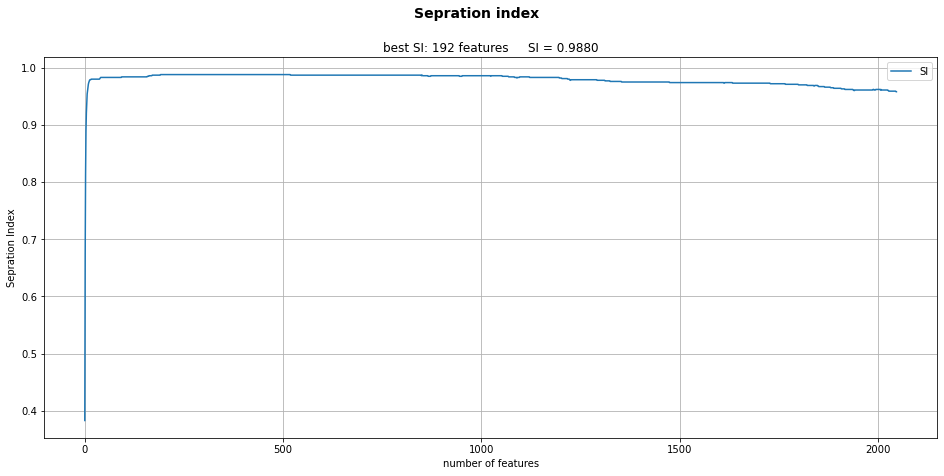

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(16, 7))


ax.plot(torch.tensor(si_n).cpu(), label='SI')
ax.set_xlabel('number of features')
ax.set_ylabel('Sepration Index')
ax.set_title(f"best SI: {best_num_features} features     SI = {best_si:1.4f}")
ax.grid(which='both')
ax.legend()

plt.suptitle('Sepration index', fontweight='bold', fontsize=14)
plt.savefig("forward selection.png")
plt.show()

In [21]:
increasing_index = features_idx[:best_num_features]
selected_indices = torch.tensor(increasing_index)

In [22]:
plt.plot(increasing_si_features )
plt.xlabel('Index')
plt.ylabel('SI')
plt.title('Selected Features')
plt.show()

In [23]:
outputs.shape

torch.Size([1000, 2048])

In [24]:
selected_features = outputs[:, selected_indices]
print(selected_features.shape)

torch.Size([1000, 192])


In [25]:
selected_label= labels.squeeze()
print(selected_label.shape)

torch.Size([1000])


In [26]:
myclassifier = nn.Sequential(
    nn.LayerNorm((int(best_num_features),),eps = 1e-06),
    nn.ReLU(inplace=True),
    nn.Flatten(),
    nn.Linear(in_features = int(best_num_features),out_features=10)
)
myclassifier = myclassifier.to(device)

In [27]:
summary(myclassifier,(best_num_features,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         LayerNorm-1                  [-1, 192]             384
              ReLU-2                  [-1, 192]               0
           Flatten-3                  [-1, 192]               0
            Linear-4                   [-1, 10]           1,930
Total params: 2,314
Trainable params: 2,314
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [28]:
optimizer = optim.SGD(myclassifier.parameters(), lr = 0.01, momentum=0.9 , weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

Epoch [1/20] - Train Loss: 0.1410 - Train Accuracy: 95.98% - Validation Loss: 0.3272 - Validation Accuracy: 90.34%
Epoch [2/20] - Train Loss: 0.0904 - Train Accuracy: 97.02% - Validation Loss: 0.3555 - Validation Accuracy: 90.06%
Epoch [3/20] - Train Loss: 0.0867 - Train Accuracy: 97.11% - Validation Loss: 0.3377 - Validation Accuracy: 90.48%
Epoch [4/20] - Train Loss: 0.0879 - Train Accuracy: 97.09% - Validation Loss: 0.3441 - Validation Accuracy: 90.32%
Epoch [5/20] - Train Loss: 0.0860 - Train Accuracy: 97.24% - Validation Loss: 0.3305 - Validation Accuracy: 90.54%
Epoch [6/20] - Train Loss: 0.0868 - Train Accuracy: 97.13% - Validation Loss: 0.3448 - Validation Accuracy: 90.30%
Epoch [7/20] - Train Loss: 0.0856 - Train Accuracy: 97.19% - Validation Loss: 0.3442 - Validation Accuracy: 90.22%
Epoch [8/20] - Train Loss: 0.0816 - Train Accuracy: 97.33% - Validation Loss: 0.3459 - Validation Accuracy: 89.82%
Epoch [9/20] - Train Loss: 0.0834 - Train Accuracy: 97.26% - Validation Loss: 0.

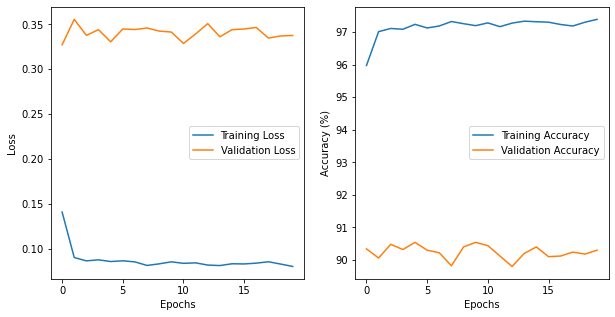

In [29]:
num_epochs = 20
train_accuracy = []
val_accuracy = []
val_losses = []
train_losses = []
for epoch in range(num_epochs):
    
    myclassifier.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        features = model(images)
        #print(features.shape)
        features2 = features.view(features.shape[0],-1)
        #print(features2.shape)
        selected = features2[:, selected_indices]
        #print(selected.shape)
        selected = selected.detach()
        optimizer.zero_grad()
        outputs = myclassifier(selected)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy.append(100 * correct / total)
    train_losses.append(running_loss / len(train_loader))

    # Validation
    myclassifier.eval()
    with torch.no_grad():
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            val_feat = model(images)
            val_feat2 = val_feat.view(val_feat.shape[0],-1)
            val_selected = val_feat2[:, selected_indices]
            val_selected = val_selected.detach()
            outputs = myclassifier(val_selected)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
        val_accuracy.append(100 * val_correct / val_total)
        val_losses.append(val_running_loss / len(val_loader))
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_losses[-1]:.4f} - Train Accuracy: {train_accuracy[-1]:.2f}% - Validation Loss: {val_losses[-1]:.4f} - Validation Accuracy: {val_accuracy[-1]:.2f}%")

# Plotting loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()



In [30]:
hooks = []
names = []
for name,module in model.named_modules():
    names.append(name)
    hooks.append(name)
hooks = list(set(hooks).intersection(set(get_graph_node_names(model)[0])))
print((hooks))
print((names))

selected_hook_names = []
selected_hook_classes = []

for module_name, module in model.named_modules():
    if module_name in hooks:
        selected_hook_names.append(module_name)
        selected_hook_classes.append(module.__class__.__name__)

['features.31', 'features.24', 'features.27', 'features.1', 'features.9', 'features.7', 'features.28', 'features.15', 'features.5', 'features.17', 'features.12', 'features.13', 'features.32', 'features.25', 'features.2', 'features.19', 'features.6', 'features.36', 'features.26', 'features.10', 'features.20', 'features.35', 'features.18', 'features.33', 'features.0', 'features.11', 'features.21', 'features.29', 'features.8', 'features.22', 'features.23', 'features.14', 'features.34', 'features.3', 'features.4', 'features.16', 'features.30']
['', 'features', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'features.13', 'features.14', 'features.15', 'features.16', 'features.17', 'features.18', 'features.19', 'features.20', 'features.21', 'features.22', 'features.23', 'features.24', 'features.25', 'features.26', 'features.27', 'features.28', 'features.29

In [35]:
hooks_si_train = []
layer_names = []
layer_indices = []

#classes = torch.tensor(train_dataset.targets)
imgs, labels = next(iter(balanced10_train_loader))
imgs, labels = imgs.to(device), labels.to(device)

with torch.no_grad():
    for i, hook in enumerate(selected_hook_names):
        hooked_model = create_feature_extractor(model, return_nodes=[hook]).to(device)
        features = hooked_model(imgs)[hook]
        instance = center_si(features, labels, classes= range(10))
        hooks_si_train.append(instance.detach())
        
        # Store layer name and index for plotting
        layer_names.append(hook)
        layer_indices.append(i)

        print("{:<30} : {} \tcsi = {:.4f}".format(hook, list(features.shape), hooks_si_train[-1]))


features.0                     : [1000, 64, 32, 32] 	csi = 0.4040
features.1                     : [1000, 64, 32, 32] 	csi = 0.4350
features.2                     : [1000, 64, 32, 32] 	csi = 0.5130
features.3                     : [1000, 64, 32, 32] 	csi = 0.4760
features.4                     : [1000, 64, 32, 32] 	csi = 0.5110
features.5                     : [1000, 64, 32, 32] 	csi = 0.6110
features.6                     : [1000, 64, 16, 16] 	csi = 0.5760
features.7                     : [1000, 128, 16, 16] 	csi = 0.5210
features.8                     : [1000, 128, 16, 16] 	csi = 0.5260
features.9                     : [1000, 128, 16, 16] 	csi = 0.7170
features.10                    : [1000, 128, 16, 16] 	csi = 0.6840
features.11                    : [1000, 128, 16, 16] 	csi = 0.6810
features.12                    : [1000, 128, 16, 16] 	csi = 0.7860
features.13                    : [1000, 128, 8, 8] 	csi = 0.7550
features.14                    : [1000, 256, 8, 8] 	csi = 0.7220
featur

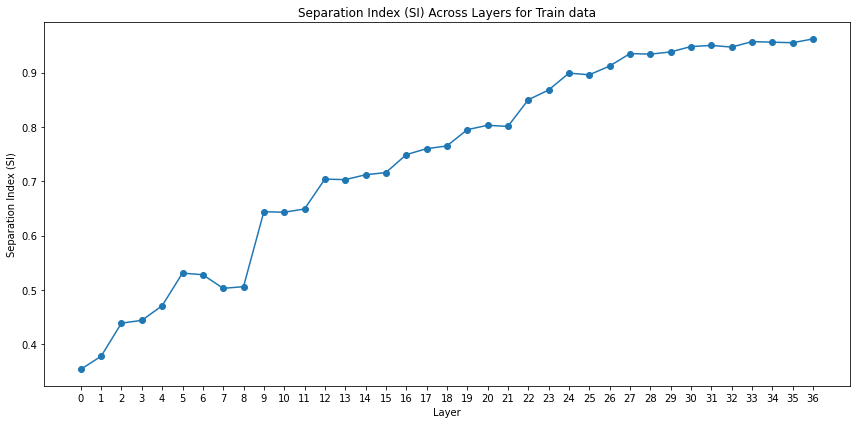

In [32]:
hooks_si_train = [si.cpu().numpy() for si in hooks_si_train]
plt.figure(figsize=(12, 6))
# Plotting the SI based on the number of layers
plt.plot(layer_indices, hooks_si_train, marker='o')
plt.xticks(layer_indices)
plt.xlabel('Layer')
plt.ylabel('Separation Index (SI)')
plt.title('Separation Index (SI) Across Layers for Train data')
plt.tight_layout()
plt.show()

In [33]:
hooks_si_test = []

layer_names_test = []
layer_indices_test = []

imgs_test, labels_test = next(iter(balanced10_test_loader))
imgs_test, labels_test = imgs_test.to(device), labels_test.to(device)

with torch.no_grad():
    for i, hook in enumerate(selected_hook_names):
        hooked_model = create_feature_extractor(model, return_nodes=[hook]).to(device)
        features_test = hooked_model(imgs_test)[hook]
        instance_test = center_si(features_test, labels_test, classes= range(10))
        hooks_si_test.append(instance_test.detach())
        
        # Store layer name and index for plotting
        layer_names_test.append(hook)
        layer_indices_test.append(i)

        print("{:<30} : {} \tsi = {:.4f}".format(hook, list(features_test.shape), hooks_si_test[-1]))


features.0                     : [100, 64, 32, 32] 	si = 0.7500
features.1                     : [100, 64, 32, 32] 	si = 0.8500
features.2                     : [100, 64, 32, 32] 	si = 0.9400
features.3                     : [100, 64, 32, 32] 	si = 0.9500
features.4                     : [100, 64, 32, 32] 	si = 0.9400
features.5                     : [100, 64, 32, 32] 	si = 0.9800
features.6                     : [100, 64, 16, 16] 	si = 0.9700
features.7                     : [100, 128, 16, 16] 	si = 0.9500
features.8                     : [100, 128, 16, 16] 	si = 0.9600
features.9                     : [100, 128, 16, 16] 	si = 0.9700
features.10                    : [100, 128, 16, 16] 	si = 0.9700
features.11                    : [100, 128, 16, 16] 	si = 0.9700
features.12                    : [100, 128, 16, 16] 	si = 1.0000
features.13                    : [100, 128, 8, 8] 	si = 0.9900
features.14                    : [100, 256, 8, 8] 	si = 0.9700
features.15                    : [10

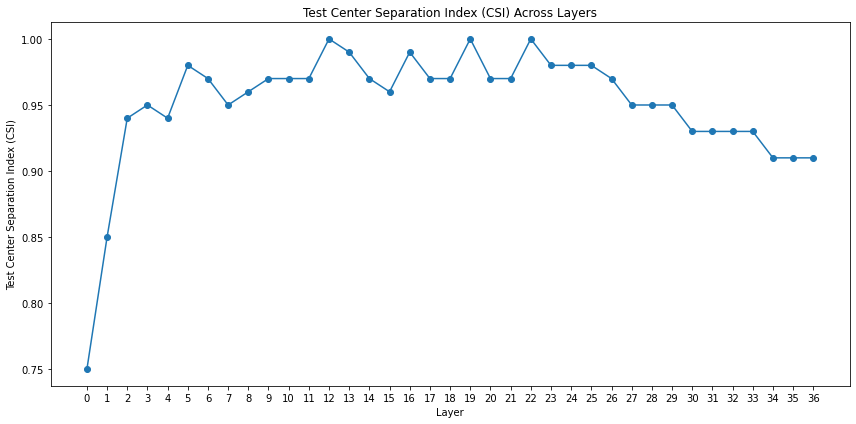

In [34]:
import matplotlib.pyplot as plt

hooks_si_test = [si.cpu().numpy() for si in hooks_si_test]
plt.figure(figsize=(12, 6))
plt.plot(layer_indices_test, hooks_si_test, marker='o')
plt.xticks(layer_indices_test)
plt.xlabel('Layer')
plt.ylabel('Test Center Separation Index (CSI)')
plt.title('Test Center Separation Index (CSI) Across Layers')
plt.tight_layout()
plt.show()